## week12: Convolutional neural networks

Inspiration for this notebook is taken from YSDA materials

__Colab is highly recommended to work with this notebook__

_before we start: please, run the following cell_

In [1]:
! wget https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
! unzip -qq data.zip -d data

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


### About CNNs
Convolutional layers extract features - quantitative representations of some attributes. 

After the extraction you can use these features for classification, for example.

<img src="img/act.png" width="800">

#### Convolution:
<img src="img/convolution.gif" width="400">

### Pooling:
<img src="img/pooling.gif" width="400">


## Let's look at popular architectures.

### VGG

<img src="img/vgg.png" width="600">

### ResNet (Shortcut + Batch Normalization)
 
<img src="img/resnet.png" width="800">
 
### GoogleNet (Predict classes for many times)
 
<img src="img/gln.png" width="800">


## Deeper layer $\to$ more complex features.

<img src="img/feat.png" width="800">

# Task: Cats vs. Dogs Classification

<img src="img/cat_dog_sota.jpg" width="600">




Let's try to build a small convolutional neural network capable of separating cat images from dog images.

## Datasets in pyTorch

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as *Pillow*, *OpenCV* are useful
- For audio, packages such as *scipy* and *librosa*
- For text, either raw *Python* or *Cython* based loading, or *NLTK* and *SpaCy* are useful

We are dealing with images, so let's have a look at image data loading in pyTorch for [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) classification competition.

The link for data downloading is in the cell below.

Training set size is reduced for performace. If you have enough computational resources, use [this link](https://www.dropbox.com/s/h2vhfxb0j3eazu1/train.zip) for downloading. 

Now let's look at the way datasets are processed in PyTorch.

In [5]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Images should be stored class-wise in PC memory: each image class have to be represented as a subfolder with the corresponding image data. `ImageFolder` takes the path to 'root' directory of such structure, e.g. DATA_PATH:

- DATA_PATH/dog/xxx.png
- DATA_PATH/dog/xxy.png
- DATA_PATH/dog/xxz.png
- DATA_PATH/cat/123.png
- DATA_PATH/cat/nsdf3.png
- DATA_PATH/cat/asd932_.png

Dataset images are of different size.

Batch generator expects a batch of tensors of the same dimensions, thus we need to rescale images in the dataset during data loading.

Let's see at the image size distributions.

In [6]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = r"data_1" # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

Let's define a transformer to be used as image preprocessing step prior to creating pyTorch image dataset

In [7]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Create an ImageFolder instance to be used during training, validation and testing phases.

In [8]:
# load dataset using torchvision.datasets.ImageFolder
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)

In [9]:
# load test data also, to be used for final evaluation
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

Save sample num for further use

In [10]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [11]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

In [12]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

In [13]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             num_workers=NUM_WORKERS)

Let's create a helper function to vizualize images from our data loaders.

In [14]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

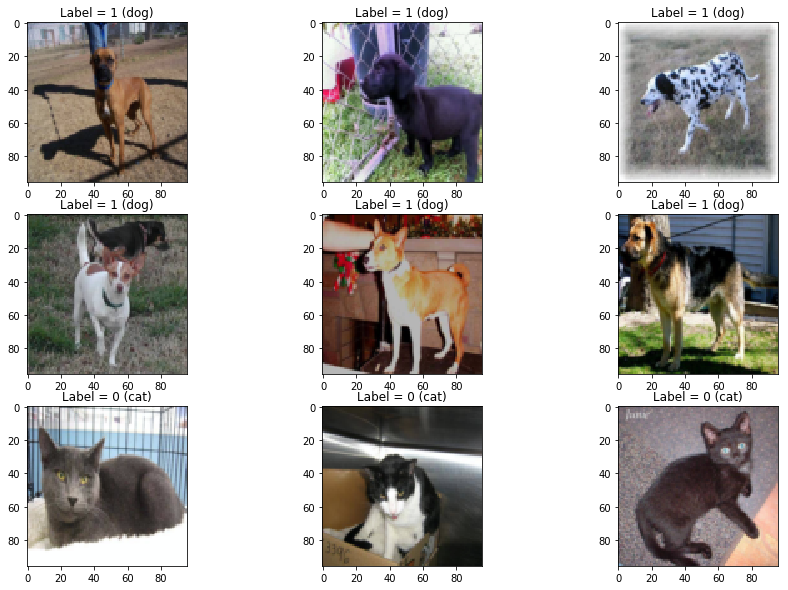

In [15]:
plot_from_batch_generator(train_batch_gen)

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.
Let's use them to create a baseline for our models

In [16]:
# a special module that converts [batch, channel, w, h] to [batch, units]: tf/keras style
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [38]:
def compute_loss(model, X_batch, y_batch):
    logits = model(X_batch)
    loss = nn.CrossEntropyLoss()
    return loss(logits ,y_batch )

Prepare separate functions for model training and evaluation

In [40]:
def train_model(model, train_batch_generator, val_batch_generator, opt, ckpt_name=None, n_epochs=EPOCH_NUM):
    train_loss = []
    val_accuracy = []
    best_model = None
    top_val_accuracy = 0
    
    for epoch in range(n_epochs):
        start_time = time.time()

        
        # Train phase
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training'):
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            #out = model(X_batch)
            loss = compute_loss(model , X_batch , y_batch)
            loss.backward()
            opt.step()
            # YOUR CODE HERE
            train_loss.append(loss.cpu().data.numpy())
        
        # Evaluation phase
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_batch_generator:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

            
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            # print('top val accuracy: %.3f' % top_val_accuracy)
            # save checkpoint of the best model to disk
            with open(ckpt_name, 'wb') as f: torch.save(model, f)
        
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_value))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy_value))
        custom_objects = (train_loss, val_accuracy)
        
    return best_model, opt, custom_objects

In [34]:
def test_model(model, test_batch_generator, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_batch_generator:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print("  {} accuracy:\t\t{:.2f} %".format(subset, test_accuracy * 100))
    if test_accuracy * 100 > 90:
        print("Amazing!")
    elif test_accuracy * 100 > 70:
        print("Good!")
    else:
        print("We need more magic! Follow instructons below")
    return test_accuracy

## Task 0: Multi-layer fully-connected network

Look at the CNN structure proposed below.

We will use this model as a baseline for classification task.

As you already know, fully-connetcted networks are not translation invariant and perform worse on image data, so resulting accuracy will be lower than for convolutional neural networks.

In [35]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * SIZE_H * SIZE_W, 256))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(0.05))
model.add_module('dense3', nn.Linear(256, 128))
model.add_module('dense3_relu', nn.ReLU())
model.add_module('dropout3', nn.Dropout(0.05))
model.add_module('dense4_logits', nn.Linear(128, NUM_CLASSES)) # logits for NUM_CLASSES=2: cats and dogs
model.add_module('dense4_preds', nn.Sigmoid())                 # predictions for NUM_CLASSES=2: cats and dogs

model = model.to(device)

Print model summary for sanity check:

In [36]:
summary(model, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                  [-1, 256]       7,078,144
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
           Sigmoid-9                    [-1, 2]               0
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.22
Params size (MB): 27.13
Estimated Total Size (MB): 27.45
-------------------------------------

Define a loss function to be optimized during training.

### Training on minibatches
* We got 11k images (22k for full train set), that's way too many for a full-batch SGD. Let's train on minibatches instead

In [41]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
opt.zero_grad()
ckpt_name = 'model_base.ckpt'
model, opt, custom_objects = train_model(
    model,
    train_batch_gen,
    val_batch_gen, opt,
    ckpt_name=ckpt_name,
    n_epochs=7
)


Epoch 1 of 7 took 48.693s


C:\Apps\anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


  training loss (in-iteration): 	0.656617
  validation accuracy: 			59.43 %



Epoch 2 of 7 took 27.020s
  training loss (in-iteration): 	0.610516
  validation accuracy: 			60.06 %



Epoch 3 of 7 took 28.299s
  training loss (in-iteration): 	0.581710
  validation accuracy: 			61.96 %



Epoch 4 of 7 took 38.654s
  training loss (in-iteration): 	0.554607
  validation accuracy: 			61.62 %



Epoch 5 of 7 took 33.861s
  training loss (in-iteration): 	0.533426
  validation accuracy: 			63.27 %



Epoch 6 of 7 took 26.940s
  training loss (in-iteration): 	0.512769
  validation accuracy: 			62.11 %



Epoch 7 of 7 took 28.017s
  training loss (in-iteration): 	0.492076
  validation accuracy: 			63.71 %


Don't wait for too many epochs. You can interrupt training after 5-15 epochs once validation accuracy stops going up.
```

```

```

```

```

```

### Evaluate the best model using test set

In [42]:
best_model = None
with open(ckpt_name, 'rb') as f:
    best_model = torch.load(f)

val_acc = test_model(best_model, val_batch_gen, 'val')
test_acc = test_model(best_model, test_batch_gen, 'test')

Results:
  val accuracy:		63.71 %
We need more magic! Follow instructons below
Results:
  test accuracy:		65.86 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3 classic convolutional blocks `convolution->relu->pool`: 
  * 3x3 convolution with 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout 
* Dense layer with 256 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

In [59]:
model_cnn = nn.Sequential()

# Your code here: CONV->POOL->CONV-POOL->... as many as you wish
model_cnn.add_module('conv_1' ,  nn.Conv2d(3, 32, 3) )
model_cnn.add_module('relu_7', nn.ReLU())
model_cnn.add_module('pool_1' , nn.MaxPool2d(2) )

# End of your code here
# global average pooling
model_cnn.add_module('gap_5', nn.AvgPool2d(20))
# dropout for regularization
model_cnn.add_module('dropout_5', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc_6', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

# move model to computing device
model_cnn = model_cnn.to(device)


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [60]:
summary(model_cnn, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             896
              ReLU-2           [-1, 32, 94, 94]               0
         MaxPool2d-3           [-1, 32, 47, 47]               0
         AvgPool2d-4             [-1, 32, 2, 2]               0
           Dropout-5             [-1, 32, 2, 2]               0
           Flatten-6                  [-1, 128]               0
            Linear-7                  [-1, 256]          33,024
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                    [-1, 2]             514
          Sigmoid-11                    [-1, 2]               0
Total params: 34,434
Trainable params: 34,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/ba

#### Training

In [61]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
opt.zero_grad()
ckpt_name_cnn='model_cnn.ckpt'
model_cnn, opt, custom_objects_cnn = train_model(model_cnn,
                                                 train_batch_gen,
                                                 val_batch_gen,
                                                 opt,
                                                 ckpt_name=ckpt_name_cnn,
                                                 n_epochs=15
                                                )


Epoch 1 of 15 took 27.095s
  training loss (in-iteration): 	0.686527
  validation accuracy: 			57.03 %



Epoch 2 of 15 took 27.224s
  training loss (in-iteration): 	0.671255
  validation accuracy: 			58.76 %



Epoch 3 of 15 took 27.915s
  training loss (in-iteration): 	0.657976
  validation accuracy: 			59.94 %



Epoch 4 of 15 took 27.569s
  training loss (in-iteration): 	0.649100
  validation accuracy: 			60.24 %



Epoch 5 of 15 took 27.949s
  training loss (in-iteration): 	0.645765
  validation accuracy: 			60.44 %



Epoch 6 of 15 took 27.107s
  training loss (in-iteration): 	0.643516
  validation accuracy: 			61.99 %



Epoch 7 of 15 took 27.466s
  training loss (in-iteration): 	0.637708
  validation accuracy: 			62.22 %



Epoch 8 of 15 took 26.964s
  training loss (in-iteration): 	0.637662
  validation accuracy: 			62.52 %



Epoch 9 of 15 took 27.312s
  training loss (in-iteration): 	0.636686
  validation accuracy: 			63.19 %



Epoch 10 of 15 took 26.746s
  training loss (in-iteration): 	0.632394
  validation accuracy: 			62.61 %



Epoch 11 of 15 took 27.836s
  training loss (in-iteration): 	0.632130
  validation accuracy: 			63.27 %



Epoch 12 of 15 took 27.663s
  training loss (in-iteration): 	0.628730
  validation accuracy: 			62.78 %



Epoch 13 of 15 took 27.322s
  training loss (in-iteration): 	0.627250
  validation accuracy: 			63.01 %



Epoch 14 of 15 took 27.123s
  training loss (in-iteration): 	0.626277
  validation accuracy: 			63.13 %



Epoch 15 of 15 took 29.572s
  training loss (in-iteration): 	0.622313
  validation accuracy: 			63.24 %


**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```
#### Evaluation 


In [56]:
best_model_cnn = None
with open(ckpt_name_cnn, 'rb') as f:
    best_model_cnn = torch.load(f)

val_accuracy = test_model(best_model_cnn, val_batch_gen, subset='val')
test_accuracy = test_model(best_model_cnn, test_batch_gen, subset='test')

Results:
  val accuracy:		58.85 %
We need more magic! Follow instructons below
Results:
  test accuracy:		61.14 %
We need more magic! Follow instructons below


## Task 2: Fine-tuning

### In practice it is easier to use pre-trained NN

<img src="img/ft.jpg" width="600">

We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly changing some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)
 
<img src="img/resnet.png" width="800">

In [ ]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
# YOUR CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = #YOUR CODE HERE: add your own prediction part: FC layer for 2 classes

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

In [ ]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

#### Training (only for final layer)

In [ ]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=3e-4)
ckpt_name_resnet18='model_resnet_18_finetune.ckpt'

model_resnet18, opt_resnet, custom_objects = train_model(model_resnet18,
                                                         train_batch_gen, 
                                                         val_batch_gen,
                                                         opt_resnet,
                                                         ckpt_name=ckpt_name_resnet18,
                                                         n_epochs=3)

#### Evaluation

In [ ]:
best_model_resnet18=None
with open(ckpt_name_resnet18, 'rb') as f:
    best_model_resnet18 = torch.load(f)
test_model(best_model_resnet18, val_batch_gen, subset='val')
test_model(best_model_resnet18, test_batch_gen, subset='test')

### Use your own image

In [ ]:
from skimage.io import imread
from skimage.transform import resize

src_1_fp = r"img/example_1.png"
src_2_fp = r"img/example_2.png"

src_1 = imread(src_1_fp)
src_2 = imread(src_2_fp)

resized_1 = resize(src_1, (SIZE_H, SIZE_W), mode='reflect')
resized_2 = resize(src_2, (SIZE_H, SIZE_W), mode='reflect')

# convert to torch.Tensor
tensor_1 = torch.Tensor(np.transpose((resized_1/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)
tensor_2 = torch.Tensor(np.transpose((resized_2/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)

# 'cat' scores
score_1 = best_model_resnet18(tensor_1).detach().cpu().numpy()[0][0]
score_2 = best_model_resnet18(tensor_2).detach().cpu().numpy()[0][0]

In [ ]:
get_label = lambda x: ('cat' if x > 0.5 else 'dog') + ': {:.4f}'.format(x)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(src_1)
plt.title(get_label(score_1))
plt.subplot(122)
plt.imshow(src_2)
plt.title(get_label(score_2))
plt.show()

```
```


## Task 3: adding normalization and different model initialization
### Let's get back to hard work
* Improve the task 1 CNN architecture  with the following:
  * Add batch norm (with default params) between convolution and ReLU
    * nn.BatchNorm*d (1d for dense, 2d for conv)
    * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least __80%__ validation accuracy at peak.
* Use the following model class to simplify the inference


To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [ ]:
# Custom model class

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
    # YOUR CODE HERE
    # CONV 3x3 -> BN -> ReLU
    # YOUR CODE ENDS HERE
  )


class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            ## YOUR CODE HERE: repeat the same architecture as above, using conv_block_3x3
        )
        self.fc = nn.Sequential(
            # YOUR CODE HERE: FC->BN->RELU
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x

In [ ]:
# outputs are here for convenience
model_cnn_norm = MyModel(3).to(device)
summary(model_cnn_norm, (3, SIZE_H, SIZE_W))

#### Training

In [ ]:
opt = torch.optim.Adam(model_cnn_norm.parameters(), lr=3e-4)
ckpt_name_cnn_norm='model_cnn_norm.ckpt'
model_cnn_norm, opt, custom_objects_cnn_norm = train_model(model_cnn_norm,
                                                           train_batch_gen,
                                                           val_batch_gen,
                                                           opt,
                                                           ckpt_name=ckpt_name_cnn_norm)

#### Evaluation

In [ ]:
best_model_cnn_norm = None
with open(ckpt_name_cnn_norm, 'rb') as f:
    best_model_cnn_norm = torch.load(f)
test_model(best_model_cnn_norm, val_batch_gen, subset='val')
test_model(best_model_cnn_norm, test_batch_gen, subset='test')


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 4: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly changes image color (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

<img src="img/augmentation.png" width="500">

In [ ]:
transformer_augmented = transforms.Compose([
    # YOUR CODE HERE
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)]
)

In [ ]:
# Load dataset using ImageFolder using transformer with augmentation
# Note: We do not use augmentation for validation or testing
train_dataset_aug = # YOUR CODE HERE: creade dataset using the transformer above
train_aug_batch_gen = torch.utils.data.DataLoader(train_dataset_aug, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

Let's look at some image examples

In [ ]:
plot_from_batch_generator(train_aug_batch_gen)

Note that we did not change test_dataset, as we do not need to augment image data in it. 

Let's retrain our model, saving it to another variable

#### Training

In [ ]:
model_cnn_aug = MyModel(3).to(device)
opt = torch.optim.Adam(model_cnn_aug.parameters(), lr=3e-4)
ckpt_name_aug='model_cnn_aug.ckpt'
model_cnn_aug, opt, custom_objects_cnn_aug = train_model(model_cnn_aug,
                                                          train_aug_batch_gen,
                                                          val_batch_gen,
                                                          opt,
                                                          ckpt_name=ckpt_name_aug,
                                                          n_epochs=2 * EPOCH_NUM)

#### Evaluation

In [ ]:
best_model_cnn_aug=None
with open(ckpt_name_aug, 'rb') as f:
    best_model_cnn_aug = torch.load(f)
val_acc = test_model(best_model_cnn_aug, val_batch_gen, subset='val')
test_acc = test_model(best_model_cnn_aug, test_batch_gen, subset='test')

## Dark Magic 

<img src="img/dm.png" width="600">